# Recursive forecasting example

In this notebook we will show how to use trend features in a recursive forecasting workflow where we also have features built from the target (e.g., lag & window features).

In [1]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [2]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

## Plot the data

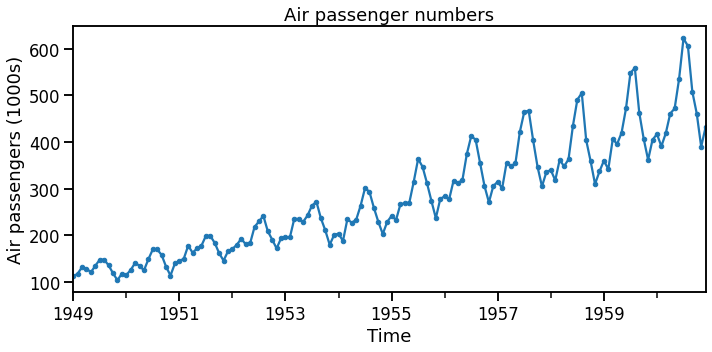

In [3]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

# Let's build some forecasts!

Let's build a recursive forecast and see how our trend feature can help!

In [4]:
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.base import clone

# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
                                       # for this feature

In [5]:
# The data is monthly, let's work with pandas Period.
df = data.copy()
df.index = df.index.to_period("M")
df.head()

,y
ds,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


Specify target name.

In [6]:
target=["y"] # Note: it's in a list.
             # This ensures we'll get
             # a dataframe when using df.loc[:, target]
             # rather than a pandas Series. 
             # This can also be useful if we have
             # multiple targets.

Prepare our transformers.

In [7]:
# Polynomial time features
time_feats = make_pipeline(
                           TimeSince(), 
                           PolynomialFeatures(degree=3, include_bias=False)
                          )


# Features computed from the target.
# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3, 12],  # Lag features.
        "mean": [[1, 12]],  # [[lag, window size]]
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

Create a pipeline to create all our features.

In [8]:
# Create features derived independent of one another
feat_eng_trafo = make_column_transformer(
    (time_feats, target),
    (lag_window_feats, target)
)

# Apply min-max scaling to all the features
feat_eng_trafo = make_pipeline(feat_eng_trafo, MinMaxScaler())

In [9]:
feat_eng_trafo

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('timesince',
                                                                   TimeSince()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['y']),
                                                 ('windowsummarizer',
                                                  WindowSummarizer(lag_feature={'lag': [1,
                                                                                        2,
                                                                                        3,
                                                                                        12],
                                                                                'mean': [[1,
                                                                                          12]]},
                                                                   target_cols=['y'],
                                                                   truncate='bfill'),
                                                  ['y'])])),
                ('minmaxscaler', MinMaxScaler())])

Let's check how our feature engineering pipeline behaves.

In [10]:
feat_eng_trafo.fit_transform(df)

,pipeline__time_since_1949-01,pipeline__time_since_1949-01^2,pipeline__time_since_1949-01^3,windowsummarizer__y_lag_1,windowsummarizer__y_lag_2,windowsummarizer__y_lag_3,windowsummarizer__y_lag_12,windowsummarizer__y_mean_1_12
ds,,,,,,,,
1949-01,0.000000,0.000000,0.000000e+00,0.015444,0.015444,0.015444,0.017582,0.000000
1949-02,0.006993,0.000049,3.419731e-07,0.015444,0.015444,0.015444,0.017582,0.000000
1949-03,0.013986,0.000196,2.735784e-06,0.027027,0.015444,0.015444,0.017582,0.000000
1949-04,0.020979,0.000440,9.233272e-06,0.054054,0.027027,0.015444,0.017582,0.000000
1949-05,0.027972,0.000782,2.188628e-05,0.048263,0.054054,0.027027,0.017582,0.000000
...,...,...,...,...,...,...,...,...
1960-08,0.972028,0.944838,9.184093e-01,1.000000,0.832046,0.710425,1.000000,0.958303
1960-09,0.979021,0.958482,9.383741e-01,0.969112,1.000000,0.832046,0.789011,0.969566
1960-10,0.986014,0.972224,9.586260e-01,0.779923,0.969112,1.000000,0.665934,0.980350


Let's reset our feature engineering pipeline.

In [11]:
# We can use `clone` to return an unfitted version
# of the pipeline.
feat_eng_trafo = clone(feat_eng_trafo)

Let's build a recursive forecast.

We'll start with configuring the model, the forecast start time, the number of steps to forecast, and the forecasting horizon, and the model.

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [13]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split                                                    
forecast_start_time = pd.Period("1955-10", freq="M")

# Define number of steps to forecast.
num_of_forecast_steps = 36

# Define the model.
model = LinearRegression()

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.period_range(forecast_start_time, 
                                   periods=num_of_forecast_steps,
                                   freq="M")

# How much data in the past is needed to create our features
look_back_window_size = 12 # We need the latest 12 time periods
                           # in our predict dataframe to build our 
                           # window features.

Let's create our training dataframe.

In [14]:
# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

Let's prepare the dataframe that we will pass to `model.predict()`. This will contain some portion of time series during the training period so we can create any features that require historic data.

In [15]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this 
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period 
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([
                  df_predict,
                  pd.DataFrame(index=forecast_horizon)
                 ])

Let's compute our `X_train` and `y_train` and fit our model!

In [16]:
# --- FEATURE ENGINEERING--- #
# Create X_train and y_train
y_train = df_train[target]
X_train = feat_eng_trafo.fit_transform(df_train)

# --- MODEL TRAINING---#
# Train one-step ahead forecast model
model.fit(X_train, y_train)

LinearRegression()

Let's recursively create `X_test` and make our predictions and append them to the `df_predict` dataframe.

In [17]:
# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:    
    # Compute features during the forecast horizon
    X_test = feat_eng_trafo.transform(df_predict)
    X_test = X_test.loc[[forecast_time]] 

    # Predict one step ahead. 
    y_pred = model.predict(X_test)
    
    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_forecast`. This `df_forecast`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_predict.loc[[forecast_time], target] = y_pred

Let's retrieve our forecast and actuals during the forest horizon.

In [18]:
# --- GET FORECAST AND TEST VALUES --- #    
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

Let's create predictions on the training set using our one step ahead forecast model. This is useful to plot when debugging models.

In [19]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Let's plot the forecast!

Text(0.5, 1.0, 'Forecast with LinearRegression()')

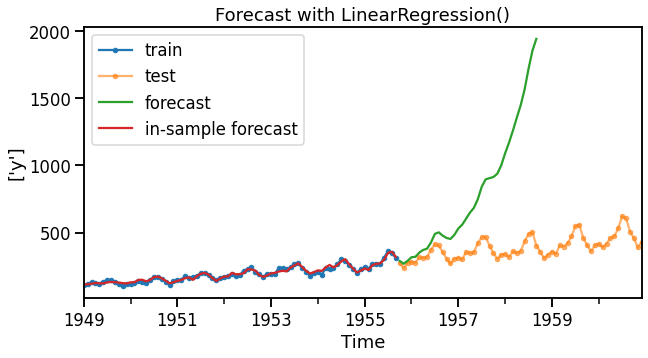

In [20]:
# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])

# Plot training set.
y_train.plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")

Let's look at the model coeffecients.

In [21]:
dict(zip(X_train.columns, model.coef_[0]))

{'pipeline__time_since_1949-01': 149.36520558767478,
 'pipeline__time_since_1949-01^2': -524.7272291718061,
 'pipeline__time_since_1949-01^3': 328.3508250766596,
 'windowsummarizer__y_lag_1': 96.98632308792853,
 'windowsummarizer__y_lag_2': -46.18273727326948,
 'windowsummarizer__y_lag_3': 5.349533683786703,
 'windowsummarizer__y_lag_12': 163.66183896833144,
 'windowsummarizer__y_mean_1_12': 81.87639862358313}

Let's compute the RMSE of this forecast.

In [22]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error

mean_squared_error(y_forecast, y_test.loc[y_forecast.index], squared=False)

615.0062486544307

We can now implement the time feature to capture trend alongside other features in a recursive forecasting workflow. We can see that the time feature can help capture the trend in the data when using linear models.

Feel free to change the dates, try different models, and different features!